# Random Forest Regression on kc_house_data_encoded_tree_step3

Workflow:
1. Setup and Imports
2. Model Hypothesis
3. Load Dataset
4. Prepare Features and Target
5. Train/Test Split
6. Baseline Random Forest (sklearn)
7. Cross Validation
8. Convert RF to PyTorch Model (running on GPU/MPS)
9. Best Model Testing (GPU)
10. Test Set Evaluation (GPU)
11. Feature Importance
12. Summary


# 1. SETUP AND IMPORTS

In [39]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from hummingbird.ml import convert

sns.set(style="whitegrid")

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)


def print_metrics(y_true, y_pred, label=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {label} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R^2 : {r2:.4f}\n")



Using device: mps


# 2. MODEL PERFORMANCE HYPOTHESIS
Hypothesis:
- A Random Forest Regressor on the tree-encoded dataset should capture
  nonlinear relationships and interactions between features more effectively
  than a linear model on the same log_price target.
- We expect:
    - Higher test R^2 than the linear baseline (potentially > 0.80),
    - Lower RMSE in log_price space,
    - Better robustness to outliers and complex patterns.
- Hyperparameter tuning (n_estimators, max_depth, etc.) should yield
  modest but meaningful improvements in cross-validated performance.



# 3. LOAD ENCODED DATASET

In [40]:
df = pd.read_csv("../data/kc_house_data_encoded_tree_step3.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (21613, 26)
   bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         3       2.25         2570      7242     2.0           0     0   
2         2       1.00          770     10000     1.0           0     0   
3         4       3.00         1960      5000     1.0           0     0   
4         3       2.00         1680      8080     1.0           0     0   

   condition  grade  sqft_above  ...  sqft_lot15  sale_year  \
0          3      7        1180  ...        5650       2014   
1          3      7        2170  ...        7639       2014   
2          3      6         770  ...        8062       2015   
3          5      7        1050  ...        5000       2014   
4          3      8        1680  ...        7503       2015   

   yr_since_renovated  log_price  is_renovated  house_age  house_age_bin  \
0                 NaN  12.309987             0         59          

# 4. PREPARE FEATURES AND TARGET


In [41]:
target_col = "log_price"

# Sanity check: make sure target exists
assert target_col in df.columns, f"{target_col} not found in dataset columns."

X = df.drop(columns=[target_col])
y = df[target_col].values

object_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Object columns in X (should ideally be none for tree-encoded data):", object_cols)

print("X shape:", X.shape)
print("y shape:", y.shape)

Object columns in X (should ideally be none for tree-encoded data): []
X shape: (21613, 25)
y shape: (21613,)


# 5. TRAIN/TEST SPLIT


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17290, 25)
X_test shape: (4323, 25)
y_train shape: (17290,)
y_test shape: (4323,)


# 6. BASELINE RANDOM FOREST (CPU TRAINED)


In [43]:
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=40,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

print_metrics(y_train, train_pred, "Baseline RF Train")
print_metrics(y_test, test_pred, "Baseline RF Test")


--- Baseline RF Train ---
RMSE: 0.0660
MAE : 0.0458
R^2 : 0.9842

--- Baseline RF Test ---
RMSE: 0.1761
MAE : 0.1250
R^2 : 0.8912



# 7. CROSS VALIDATION 

In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_rmse_baseline = -cross_val_score(
    baseline_rf,
    X,
    y,
    cv=kf,
    scoring="neg_root_mean_squared_error",
)
cv_mae_baseline = -cross_val_score(
    baseline_rf,
    X,
    y,
    cv=kf,
    scoring="neg_mean_absolute_error",
)
cv_r2_baseline = cross_val_score(
    baseline_rf,
    X,
    y,
    cv=kf,
    scoring="r2",
)

print("=== BASELINE RANDOM FOREST 5-FOLD CV ===")
print(f"RMSE: mean={cv_rmse_baseline.mean():.4f}, std={cv_rmse_baseline.std():.4f}")
print(f"MAE : mean={cv_mae_baseline.mean():.4f}, std={cv_mae_baseline.std():.4f}")
print(f"R^2 : mean={cv_r2_baseline.mean():.4f}, std={cv_r2_baseline.std():.4f}\n")


=== BASELINE RANDOM FOREST 5-FOLD CV ===
RMSE: mean=0.1766, std=0.0021
MAE : mean=0.1242, std=0.0017
R^2 : mean=0.8875, std=0.0038



# 8. CONVERT SKLEARN RF → PYTORCH RF (FOR GPU INFERENCE)


In [45]:
print("\nConverting Random Forest to PyTorch (MPS)...")

hb_model = convert(rf, "pytorch", X_train)

hb_model.to(device)

print("Conversion complete. Model is now on:", device)



Converting Random Forest to PyTorch (MPS)...
Conversion complete. Model is now on: mps


# 9. GPU PREDICTION (MPS)


In [48]:
from hummingbird.ml import convert

print("\nConverting Random Forest to PyTorch (MPS)...")

# Use NumPy array instead of DataFrame so Hummingbird treats it as a single input
hb_model = convert(rf, "pytorch", X_train.values, device=device)

print("Conversion complete. Model is now on:", device)

print("\nRunning predictions on MPS...")

# Again, pass NumPy array here
gpu_preds = hb_model.predict(X_test.values)  # returns numpy array

print_metrics(y_test, gpu_preds, "MPS RF Test (log_price)")



Converting Random Forest to PyTorch (MPS)...
Conversion complete. Model is now on: mps

Running predictions on MPS...
--- MPS RF Test (log_price) ---
RMSE: 0.1764
MAE : 0.1252
R^2 : 0.8908



# 10. TEST SET EVALUATION 


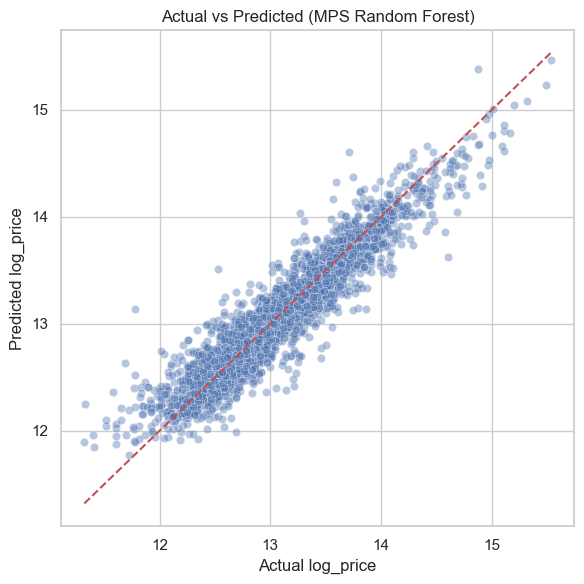

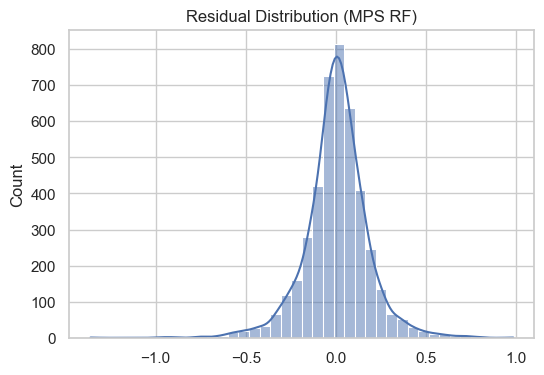

In [49]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=gpu_preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual log_price")
plt.ylabel("Predicted log_price")
plt.title("Actual vs Predicted (MPS Random Forest)")
plt.tight_layout()
plt.show()

residuals = y_test - gpu_preds

plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=40)
plt.title("Residual Distribution (MPS RF)")
plt.show()


# 11. FEATURE IMPORTANCE


Top 20 features:
                  feature  importance
8                   grade    0.339660
13                    lat    0.294103
2             sqft_living    0.178913
14                   long    0.044411
15  neighborhood_avg_sqft    0.025384
20              house_age    0.013966
9              sqft_above    0.013453
16             sqft_lot15    0.013282
3                sqft_lot    0.011796
12                zipcode    0.010437
11               yr_built    0.009188
24       lot_living_ratio    0.008068
6                    view    0.007988
5              waterfront    0.005866
1               bathrooms    0.005035
7               condition    0.004866
0                bedrooms    0.002696
17              sale_year    0.002277
10          sqft_basement    0.001895
23            above_ratio    0.001547


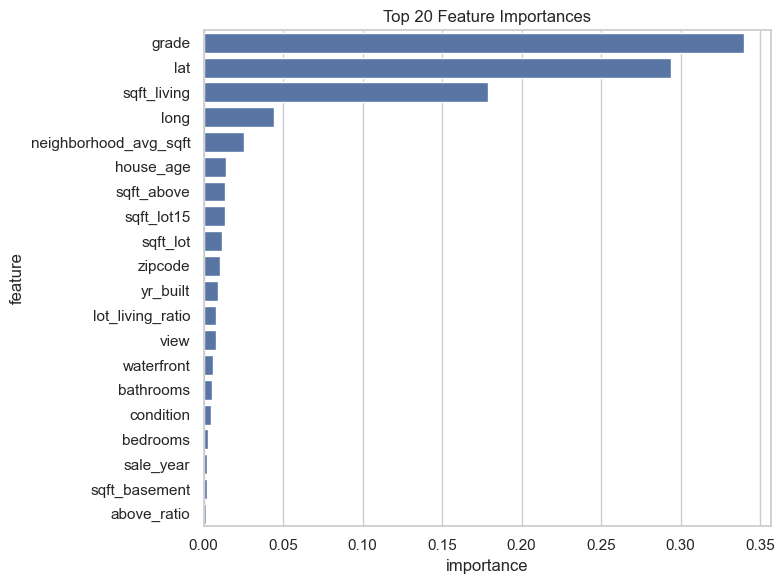

In [50]:
importances = rf.feature_importances_
feat_imp = pd.DataFrame({"feature": X.columns, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False)

print("Top 20 features:")
print(feat_imp.head(20))

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# 12. SUMMARY


In [51]:
print("\n=== SUMMARY ===")
print("Baseline RF Test R^2:", r2_score(y_test, test_pred))
print("MPS RF Test R^2:", r2_score(y_test, gpu_preds))


=== SUMMARY ===
Baseline RF Test R^2: 0.8912389005887802
MPS RF Test R^2: 0.8908028288106768
